In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold



def load_mega_metrics(file_path):
    df = pd.read_csv(file_path)
    df["Normalised Weighted Spectral Distribution (Normalized Laplacian, K=40, N=4)"] = np.real([complex(item) for item in df[combined_metrics]["Normalised Weighted Spectral Distribution (Normalized Laplacian, K=40, N=4)"].tolist()])
    return df

def get_columns(df):
    return df.columns.tolist()


def get_physical_selected_metrics():
    selected_metrics = [
                      'Diameter (hops)',
                      'Average Shortest Path Length (Hops)',
                      'Edge Density (Physical Connectivity)',
                      ]
    return selected_metrics

def get_spectral_selected_metrics():
    selected_metrics = [
                      'Normalized Spectral Radius (Un-weighted Adjacency Matrix)',
                      'Normalised Algebraic Connectivity (Normalized Laplacian)',
                      'Normalised Weighted Spectral Distribution (Normalized Laplacian, K=40, N=4)'
                      ]
    return selected_metrics

def get_spatial_selected_metrics():
    selected_metrics = [
                      'Normalized Average Link Length ',
                      'Normalized Diameter (Link Lengths)',
                      'Normalized Average Shortest Path Length (Link Lengths)'
                      ]
    return selected_metrics

def get_combined_selected_metrics():
    selected_metrics = [
                      'Diameter (hops)',
                      'Average Shortest Path Length (Hops)',
                      'Edge Density (Physical Connectivity)',
                      'Normalized Spectral Radius (Un-weighted Adjacency Matrix)',
                      'Normalised Algebraic Connectivity (Normalized Laplacian)',
                      'Normalised Weighted Spectral Distribution (Normalized Laplacian, K=40, N=4)',
                      'Normalized Average Link Length ',
                      'Normalized Diameter (Link Lengths)',
                      'Normalized Average Shortest Path Length (Link Lengths)',
                      ]
    return selected_metrics

def get_numeric_features(data, selected_metrics):
    # Select relevant features for clustering
    # data is dataframe and metrics is the set of selected metrics
    # Select metrics from df
    features = data[selected_metrics].select_dtypes(include=[np.number])
    print(features)
    return features

def apply_k_means_clustering(data, features, n_clusters = 3, n_init = 10, random_state = 42, max_iter = 300):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters = n_clusters, n_init = n_init, random_state = random_state, max_iter = max_iter)
    clusters = kmeans.fit_predict(features)
    data['Cluster'] = clusters

    # Create a table of category names and assigned topologies
    clustered_topologies = data.groupby('Cluster')['Topology Name'].apply(list).reset_index()
    clustered_topologies['Cluster'] = clustered_topologies['Cluster'].apply(lambda x: f'Class {x+1}')
    clustered_topologies.columns = ['Category Name', 'Topologies Assigned']
    clustered_topologies.to_csv('clustered_topologies.csv', index=False)

    return clusters, clustered_topologies

def compute_silhouette_avg(features, clusters):
    # Compute silhouette score
    silhouette_avg = silhouette_score(features, clusters)
    print(silhouette_avg)
    return silhouette_avg

def standardise_features(features, scaler_type = 'standard'):
    if scaler_type == 'standard':
      scaler = StandardScaler()
    elif scaler_type == 'minmax':
      scaler = MinMaxScaler()
    elif scaler == 'robust':
      scaler = RobustScaler()
    # Scale Features according to chosen type
    scaled_features = scaler.fit_transform(features)
    return scaled_features

def apply_pca(features, n_components = 2):
    # Apply PCA for 2D visualisation
    # Apply PCA to reduce dimensions to 2 for visualization
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate cumulative explained variance
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Print the variance explained by the first two components
    print("Variance explained by first two components:")
    print(f"PC1: {explained_variance_ratio[0]:.2f}")
    print(f"PC2: {explained_variance_ratio[1]:.2f}")
    print(f"Total: {explained_variance_ratio[0] + explained_variance_ratio[1]:.2f}")

    # Print cumulative variance explained
    print("\nCumulative variance explained:")
    for i, var in enumerate(cumulative_variance_ratio[:5], 1):
        print(f"First {i} PCs: {var:.2f}")
    return pca_features



# Function to compute margin for linear SVM
def compute_margin(svc):
    if svc.kernel == 'linear':
        return 1 / np.sqrt(np.sum(svc.coef_ ** 2))
    return None

# Function to perform cross-validation and compute mean accuracy and mean margin
def cross_val_svm_with_mean_margin(pca_features, clusters, cv=5, kernel='linear'):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracies = []
    margins = []

    for train_index, test_index in kf.split(pca_features):
        X_train, X_test = pca_features[train_index], pca_features[test_index]
        y_train, y_test = clusters[train_index], clusters[test_index]

        svc = SVC(kernel=kernel, probability=True)
        svc.fit(X_train, y_train)

        # Compute accuracy for this fold
        accuracy = svc.score(X_test, y_test)
        accuracies.append(accuracy)

        # Compute margin for this fold
        margin = compute_margin(svc)
        if margin is not None:
            margins.append(margin)

    # Calculate mean accuracy and mean margin
    cv_mean_accuracy = np.mean(accuracies)
    mean_margin = np.mean(margins) if margins else None

    return cv_mean_accuracy, mean_margin

def get_decision_boundaries(pca_features, clusters, kernel='linear', degree=3):
    # Train the SVM classifier
    svc = SVC(kernel=kernel, degree=degree, probability=True)
    svc.fit(pca_features, clusters)

    # Predict clusters for the PCA features to calculate metrics
    predicted_clusters = svc.predict(pca_features)
    accuracy = accuracy_score(clusters, predicted_clusters)
    f1 = f1_score(clusters, predicted_clusters, average='weighted')
    precision = precision_score(clusters, predicted_clusters, average='weighted')
    recall = recall_score(clusters, predicted_clusters, average='weighted')
    auc_roc = roc_auc_score(clusters, svc.predict_proba(pca_features), multi_class='ovr')
    conf_matrix = confusion_matrix(clusters, predicted_clusters)

    # Calculate the decision function margins
    if kernel == 'linear':
        margin = 1 / np.sqrt(np.sum(svc.coef_ ** 2))
    else:
        margin = None  # Margins are typically calculated for linear kernels

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC-ROC:", auc_roc)
    print("Confusion Matrix:\n", conf_matrix)
    print("Margin:", margin)

    # Calculate cross-validation score - computes both mean acc and mean margin
    cv_mean_accuracy, cv_mean_margin = cross_val_svm_with_mean_margin(pca_features, clusters, cv=5, kernel='linear')
    print("Cross-Validation Mean Accuracy:", cv_mean_accuracy)
    print("Cross-Validation Mean Margin:", cv_mean_margin)

    # Create a mesh grid for plotting decision boundaries
    x_min, x_max = pca_features[:, 0].min() - 1, pca_features[:, 0].max() + 1
    y_min, y_max = pca_features[:, 1].min() - 1, pca_features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Plot decision boundaries
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    return xx, yy, Z, svc, accuracy, f1, precision, recall, auc_roc, conf_matrix, margin, cv_mean_accuracy, cv_mean_margin



# Increased Quality for Journal
def plot_the_clusters_with_decision_boundaries(xx, yy, Z, pca_features, clusters, filename='clusters'):
    plt.figure(figsize=(10, 8), dpi=500)  # Set figure size and DPI for higher quality
    plt.contourf(xx, yy, Z, alpha=0.3)

    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, edgecolor='k', s=100)
    # Extract the colors used by the scatter plot
    handles, labels = scatter.legend_elements()
    labels = [f'Cluster {int(label.split("{")[1].split("}")[0])}' for label in labels]

    # plt.title('KMeans Clustering with SVC Decision Boundaries')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(handles, labels)  # Add legend with extracted colors and labels
    plt.savefig(filename, format='png', dpi=500, bbox_inches='tight')  # Save the figure with high DPI
    plt.show()


def multiple_k_mean_runs(data, features, n_clusters=3, random_state_list = [42, 7, 108], n_init = 10, max_iter = 300, filename = 'experiement_'):
    clusters_list = []
    clustered_topologies_list = []
    # Apply K-Means clustering
    for random_state in random_state_list:
        kmeans = KMeans(n_clusters = n_clusters, n_init = n_init, random_state = random_state, max_iter = max_iter)
        clusters = kmeans.fit_predict(features)
        clusters_list.append(clusters)
        data['Cluster'] = clusters

        # Create a table of category names and assigned topologies
        clustered_topologies = data.groupby('Cluster')['Topology Name'].apply(list).reset_index()
        clustered_topologies['Cluster'] = clustered_topologies['Cluster'].apply(lambda x: f'Class {x+1}')
        clustered_topologies.columns = ['Category Name', 'Topologies Assigned']
        clustered_topologies_list.append(clustered_topologies)
        clustered_topologies.to_csv(filename + 'clustered_topologies_random_state_' + str(random_state) + '.csv', index=False)

    return clusters_list, clustered_topologies_list


def get_score_and_plots(selected_metrics, file_path = 'mega_graph_metrics.csv',  n_clusters=3,
                        random_state_list = [42, 7, 108], n_init = 50, max_iter = 500, filename = 'experiment_metrics_',  kernel = 'linear', image_name = 'clusters_for_metrics'):
    # Load the dataset
    df = load_mega_metrics(file_path)

    # Get numeric features
    numeric_features = get_numeric_features(df, selected_metrics)

    # # Standardize features
    scaled_features = standardise_features(numeric_features, scaler_type='standard')

    # Apply PCA on standardised features
    pca_features = apply_pca(scaled_features, n_components = 2)

    # Multiple k means on scaled features
    clusters_list, clustered_topologies_list = multiple_k_mean_runs(df,
                                                                    pca_features,
                                                                    n_clusters=n_clusters,
                                                                    random_state_list = random_state_list,
                                                                    n_init = n_init,
                                                                    max_iter = max_iter,
                                                                    filename = filename)


    # Compute Silhoutte scores
    silhouette_avg_list = [compute_silhouette_avg(pca_features, clusters_list[0]),
                           compute_silhouette_avg(pca_features, clusters_list[1]),
                           compute_silhouette_avg(pca_features, clusters_list[2])]


    # Get decision boundaries on pca features
    xx, yy, Z, svc, accuracy, f1, precision, recall, auc_roc, conf_matrix, margin, cv_mean_accuracy, cv_mean_margin = get_decision_boundaries(pca_features,
                                            clusters_list[0],
                                            kernel = kernel)

    # Plot the clusters computed with scaled features
    plot_the_clusters_with_decision_boundaries(xx, yy, Z,
                                              pca_features,
                                              clusters_list[0],
                                              filename=image_name)


    return clusters_list, clustered_topologies_list, silhouette_avg_list

In [ ]:
spectral_metrics = get_spectral_selected_metrics()
spatial_metrics = get_spatial_selected_metrics()
combined_metrics = get_combined_selected_metrics()
physical_metrics = get_physical_selected_metrics()

In [ ]:
print("------------Spectral Metrics-------------")
print(spectral_metrics)
print("------------Spatial Metrics-------------")
print(spatial_metrics)
print("------------Physical Metrics-------------")
print(physical_metrics)
print("------------Combined Metrics-------------")
print(combined_metrics)

------------Spectral Metrics-------------
['Normalized Spectral Radius (Un-weighted Adjacency Matrix)', 'Normalised Algebraic Connectivity (Normalized Laplacian)', 'Normalised Weighted Spectral Distribution (Normalized Laplacian, K=40, N=4)']
------------Spatial Metrics-------------
['Normalized Average Link Length ', 'Normalized Diameter (Link Lengths)', 'Normalized Average Shortest Path Length (Link Lengths)']
------------Physical Metrics-------------
['Diameter (hops)', 'Average Shortest Path Length (Hops)', 'Edge Density (Physical Connectivity)']
------------Combined Metrics-------------
['Diameter (hops)', 'Average Shortest Path Length (Hops)', 'Edge Density (Physical Connectivity)', 'Normalized Spectral Radius (Un-weighted Adjacency Matrix)', 'Normalised Algebraic Connectivity (Normalized Laplacian)', 'Normalised Weighted Spectral Distribution (Normalized Laplacian, K=40, N=4)', 'Normalized Average Link Length ', 'Normalized Diameter (Link Lengths)', 'Normalized Average Shortest 

     Normalized Spectral Radius (Un-weighted Adjacency Matrix)  \
0                                             0.504116           
1                                             0.751175           
2                                             0.419708           
3                                             0.653489           
4                                             0.512495           
..                                                 ...           
100                                           0.741650           
101                                           0.726455           
102                                           0.771015           
103                                           0.567019           
104                                           0.637606           

     Normalised Algebraic Connectivity (Normalized Laplacian)  \
0                                             0.023309          
1                                             0.017729          
2           

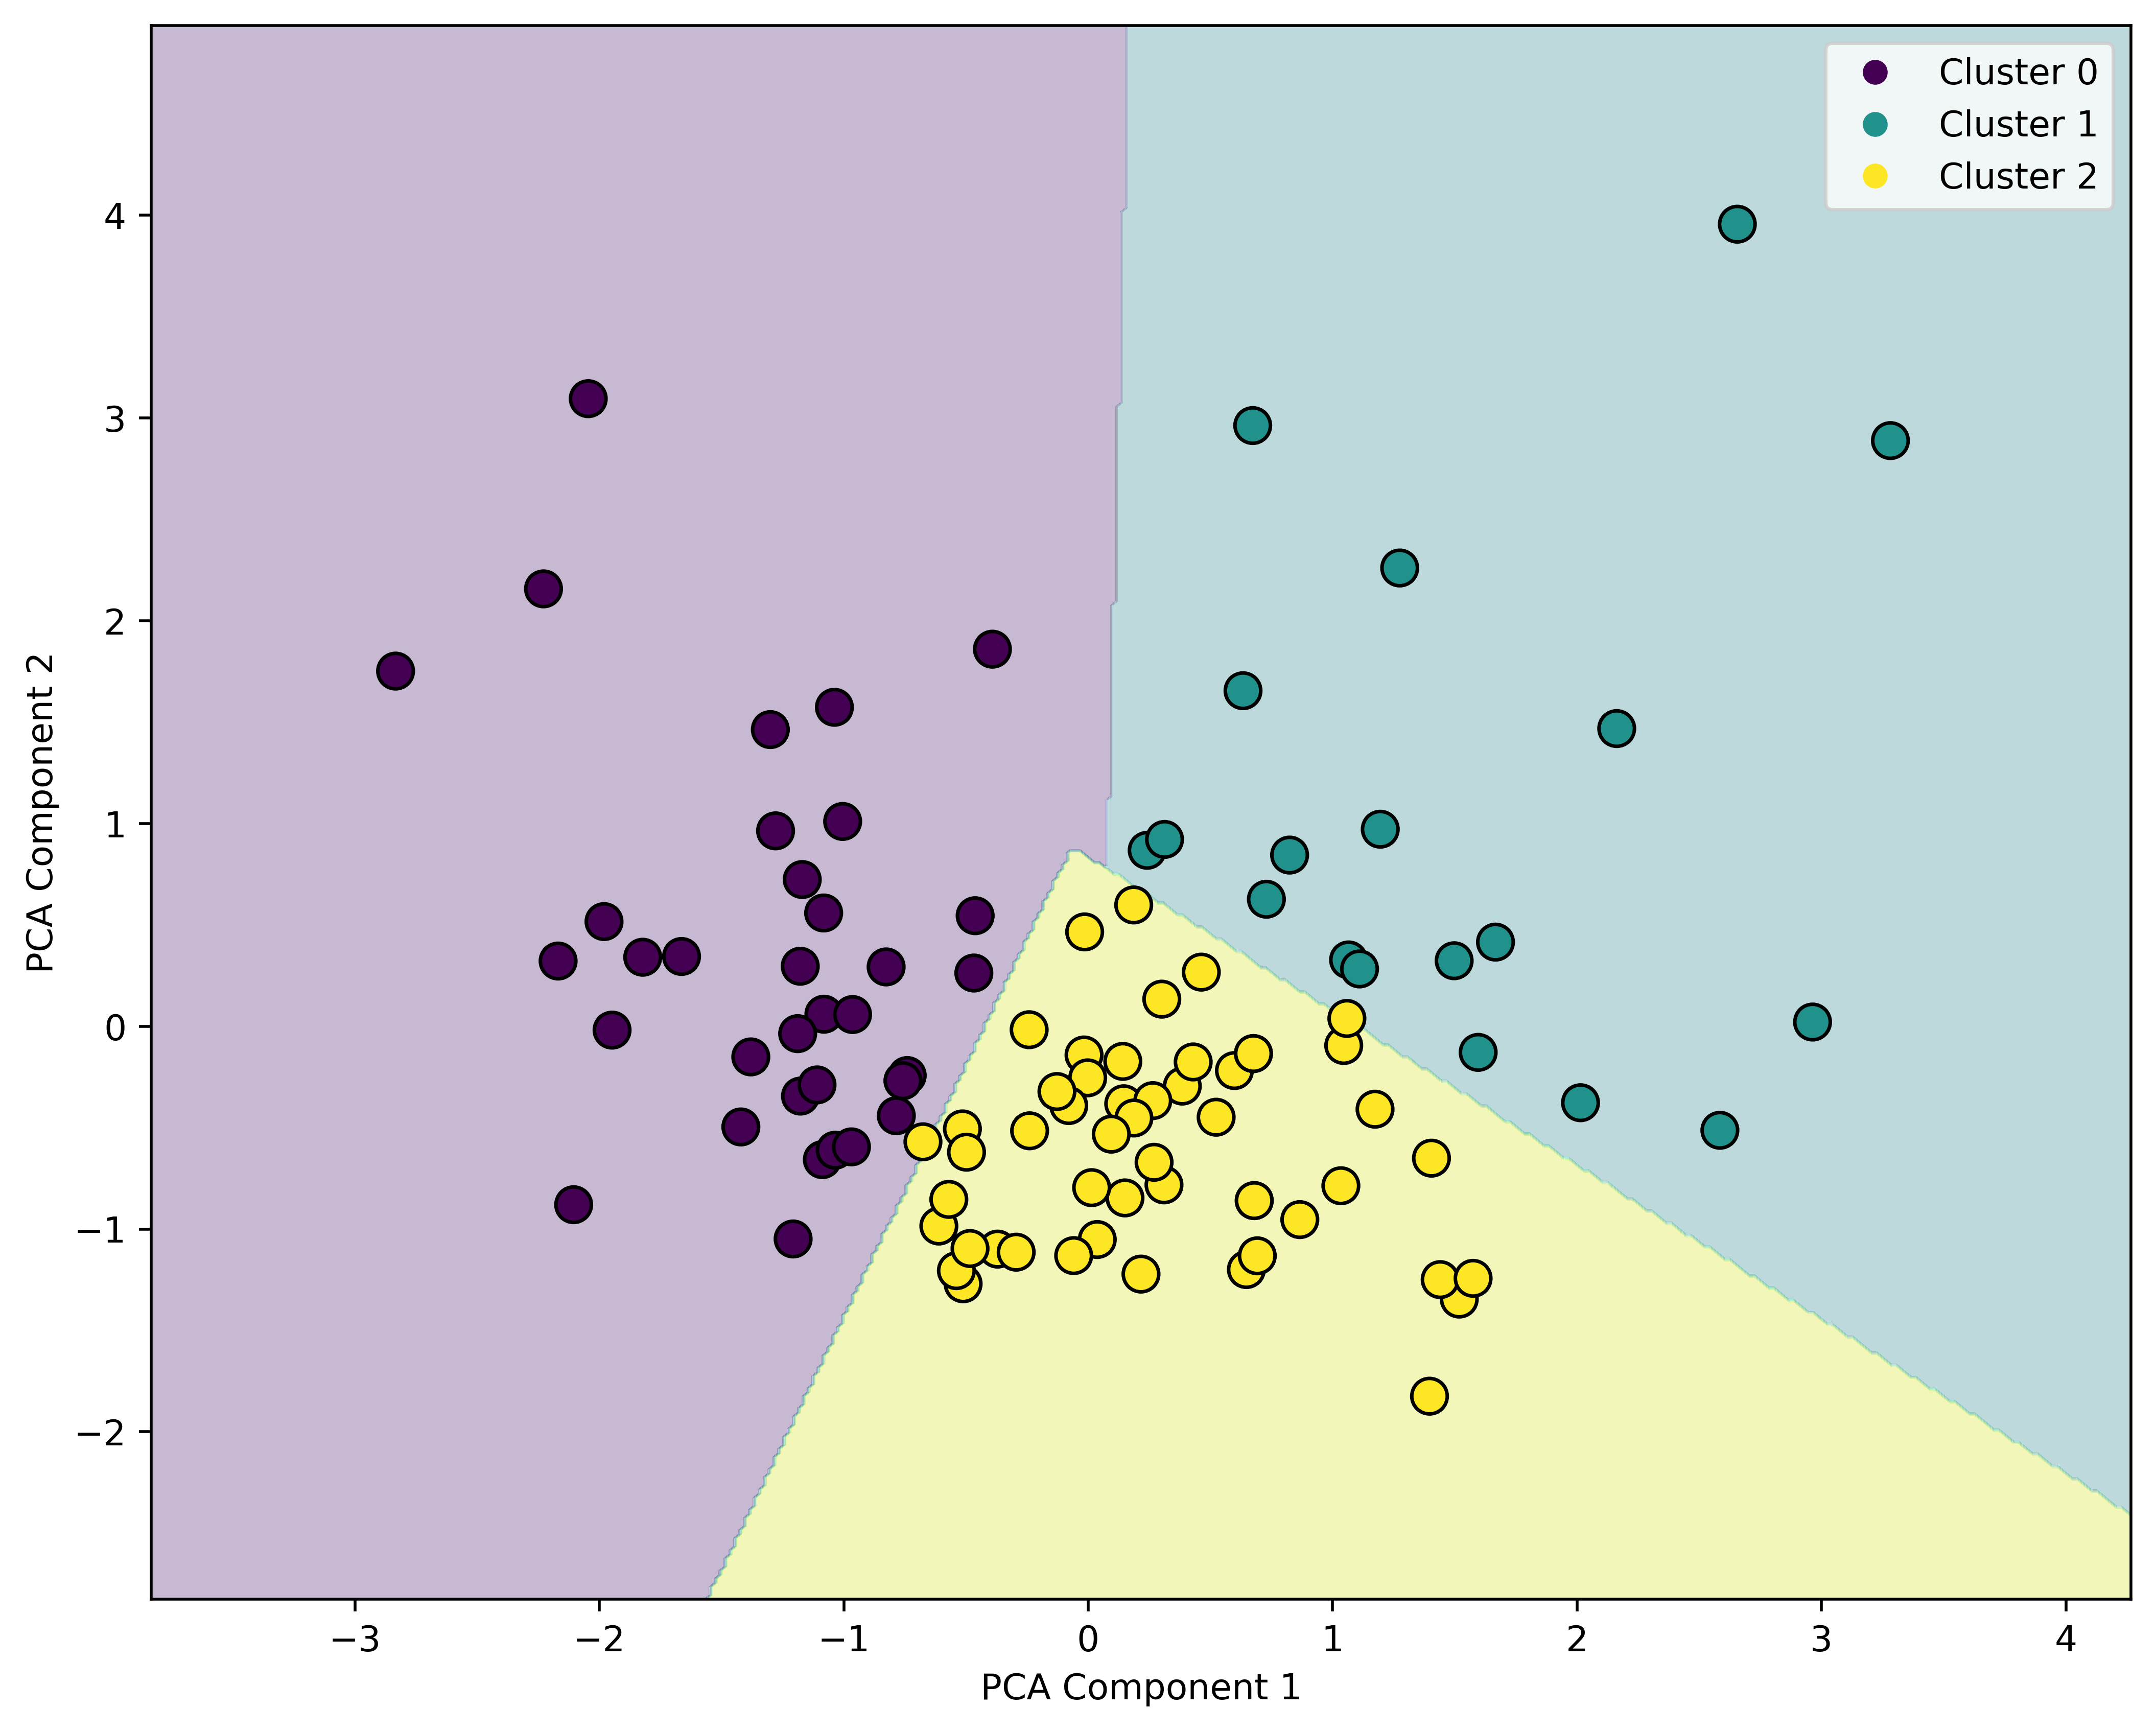

In [ ]:
spectral_clusters_list, spectral_clustered_topologies_list, spectral_silhouette_avg_list = get_score_and_plots(spectral_metrics,
                                                                                                               n_clusters=3,
                                                                                                               n_init = 150,
                                                                                                               max_iter = 1500 )


     Normalized Average Link Length   Normalized Diameter (Link Lengths)  \
0                           0.018182                            0.264394   
1                           0.012658                            0.188754   
2                           0.019608                            0.167524   
3                           0.040000                            0.314304   
4                           0.027778                            0.232345   
..                               ...                                 ...   
100                         0.041667                            0.283588   
101                         0.037037                            0.400281   
102                         0.100000                            0.602948   
103                         0.035714                            0.208678   
104                         0.037037                            0.342348   

     Normalized Average Shortest Path Length (Link Lengths)  
0                        

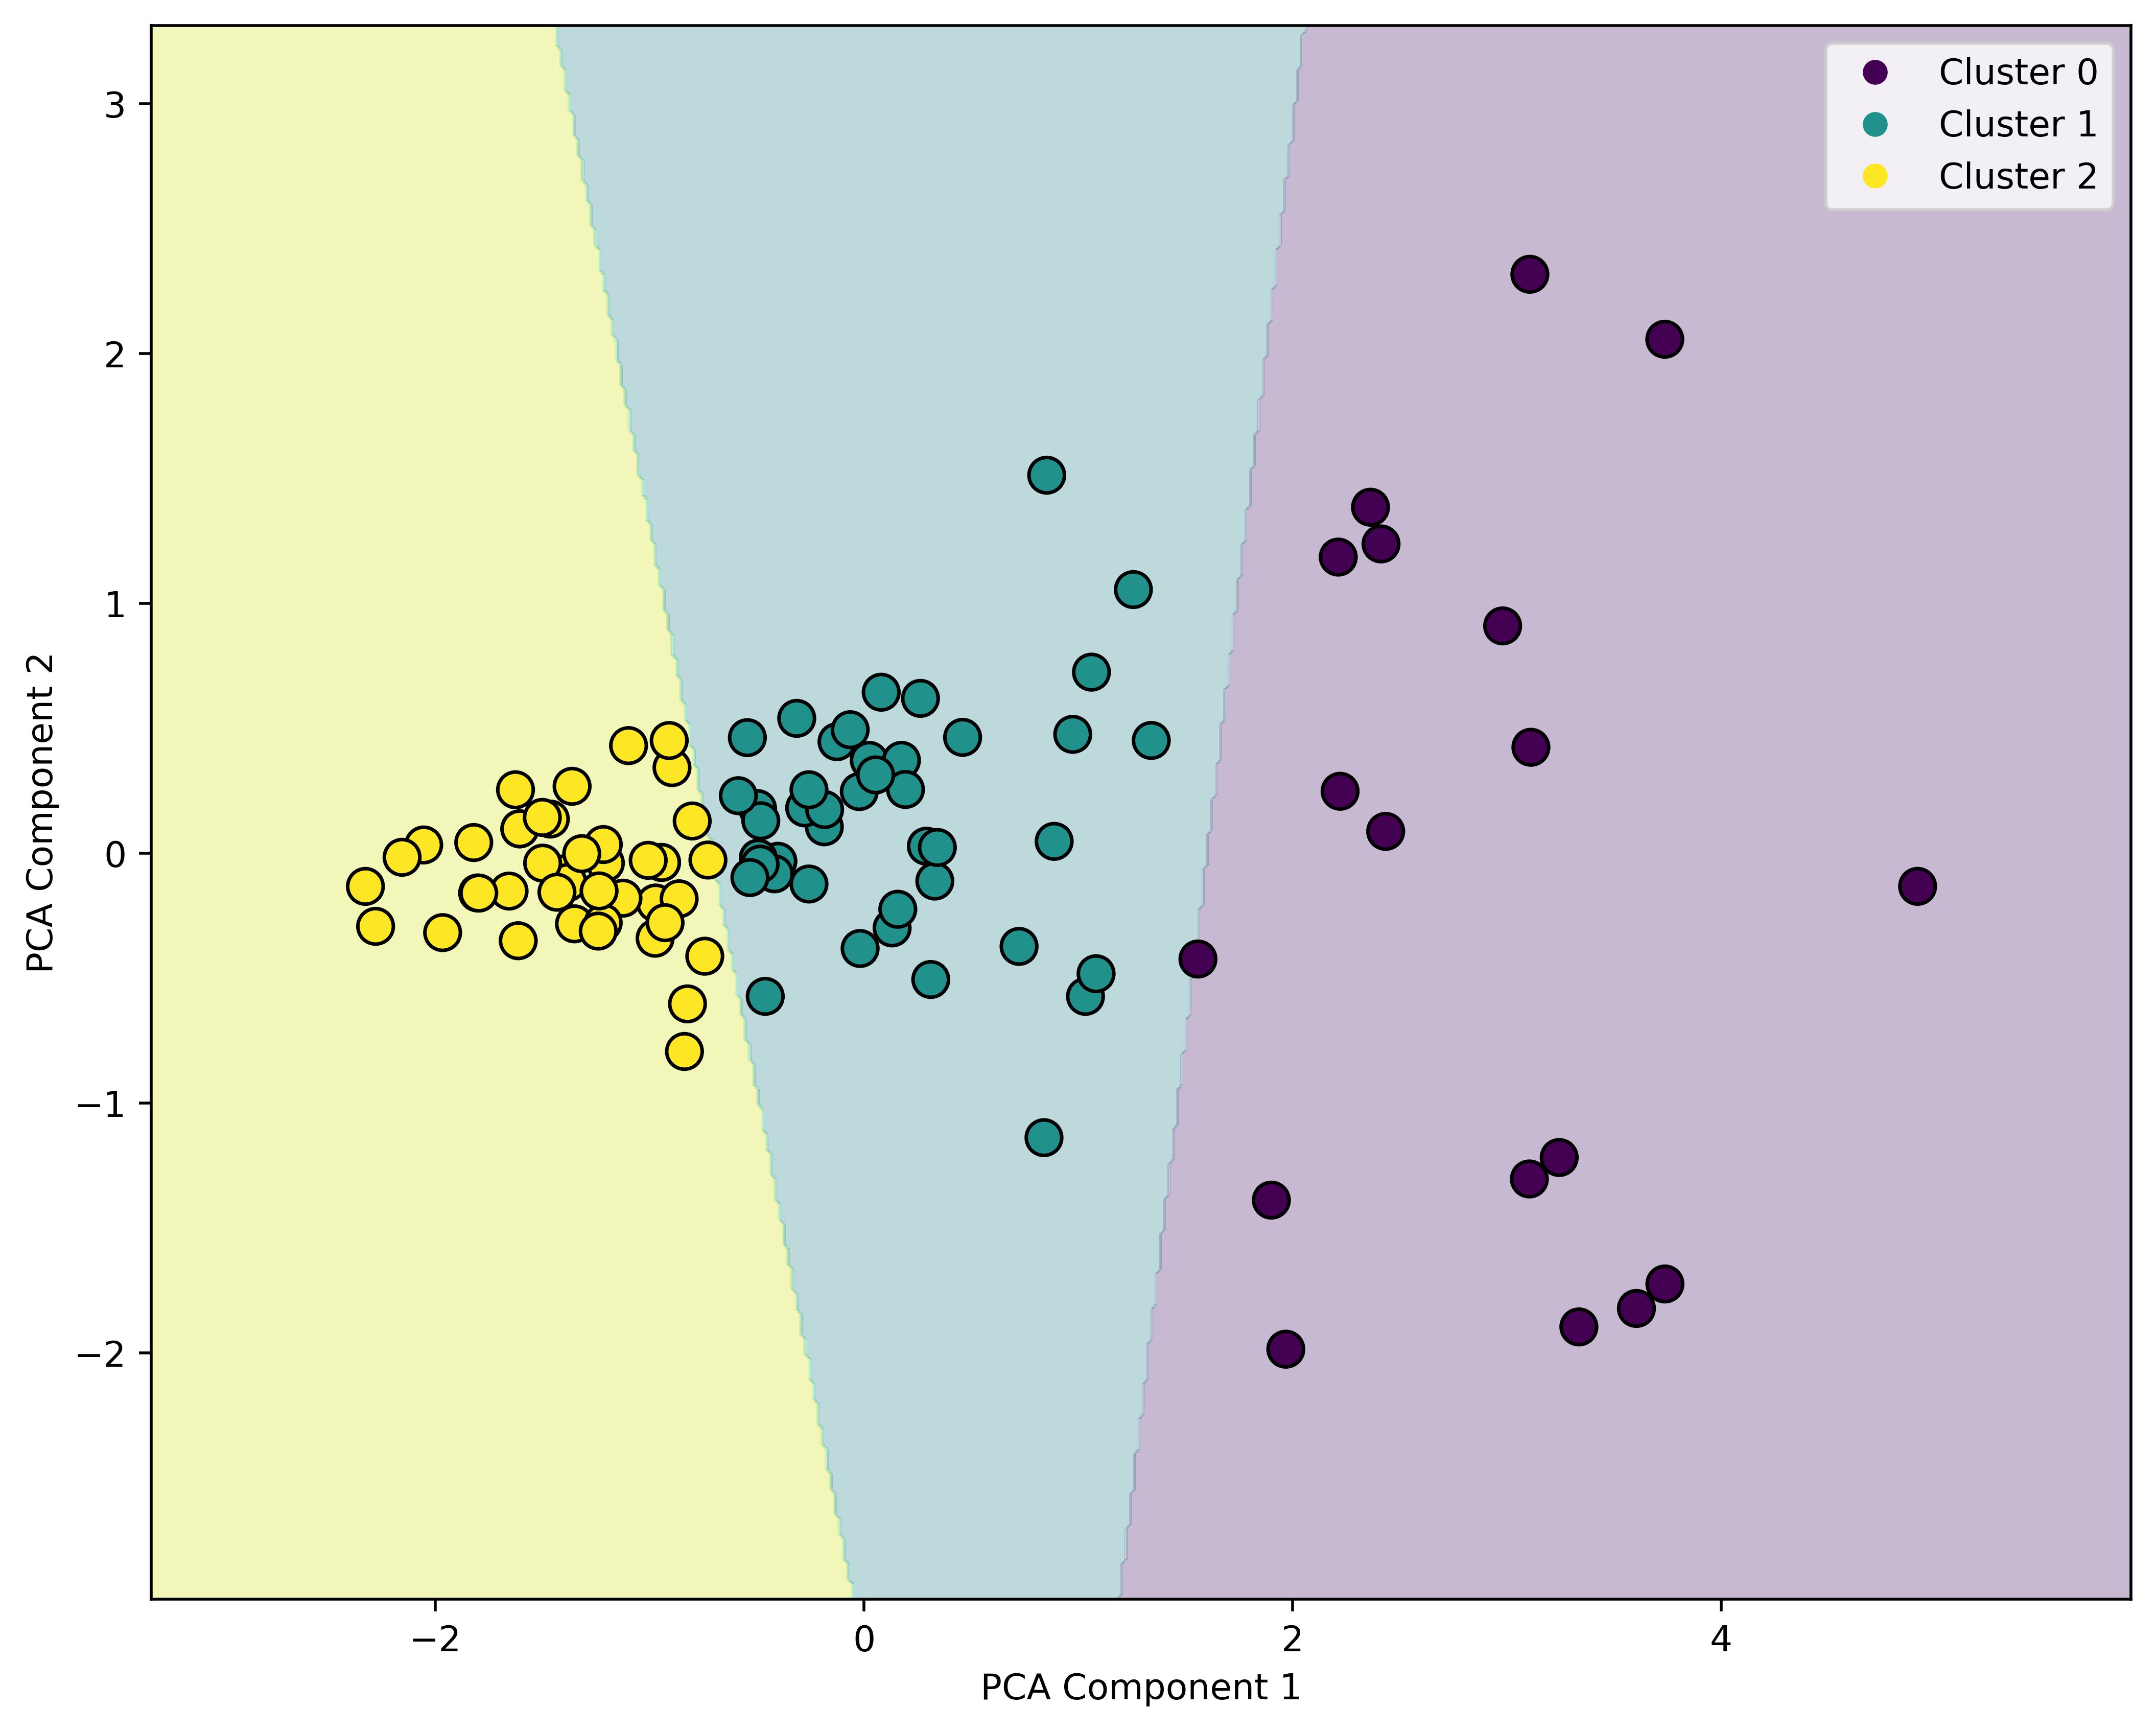

In [ ]:
spatial_clusters_list, spatial_clustered_topologies_list, spatial_silhouette_avg_list = get_score_and_plots(spatial_metrics,
                                                                                                               n_clusters=3,
                                                                                                               n_init = 150,
                                                                                                               max_iter = 1500 )

     Diameter (hops)  Average Shortest Path Length (Hops)  \
0                 13                             5.440580   
1                 15                             6.084181   
2                  5                             3.085714   
3                  7                             3.333333   
4                  5                             2.532468   
..               ...                                  ...   
100                6                             2.699346   
101                9                             3.642857   
102                7                             3.000000   
103                6                             2.766082   
104                9                             4.275362   

     Edge Density (Physical Connectivity)  
0                                0.053140  
1                                0.044633  
2                                0.080952  
3                                0.119048  
4                                0.155844  
.. 

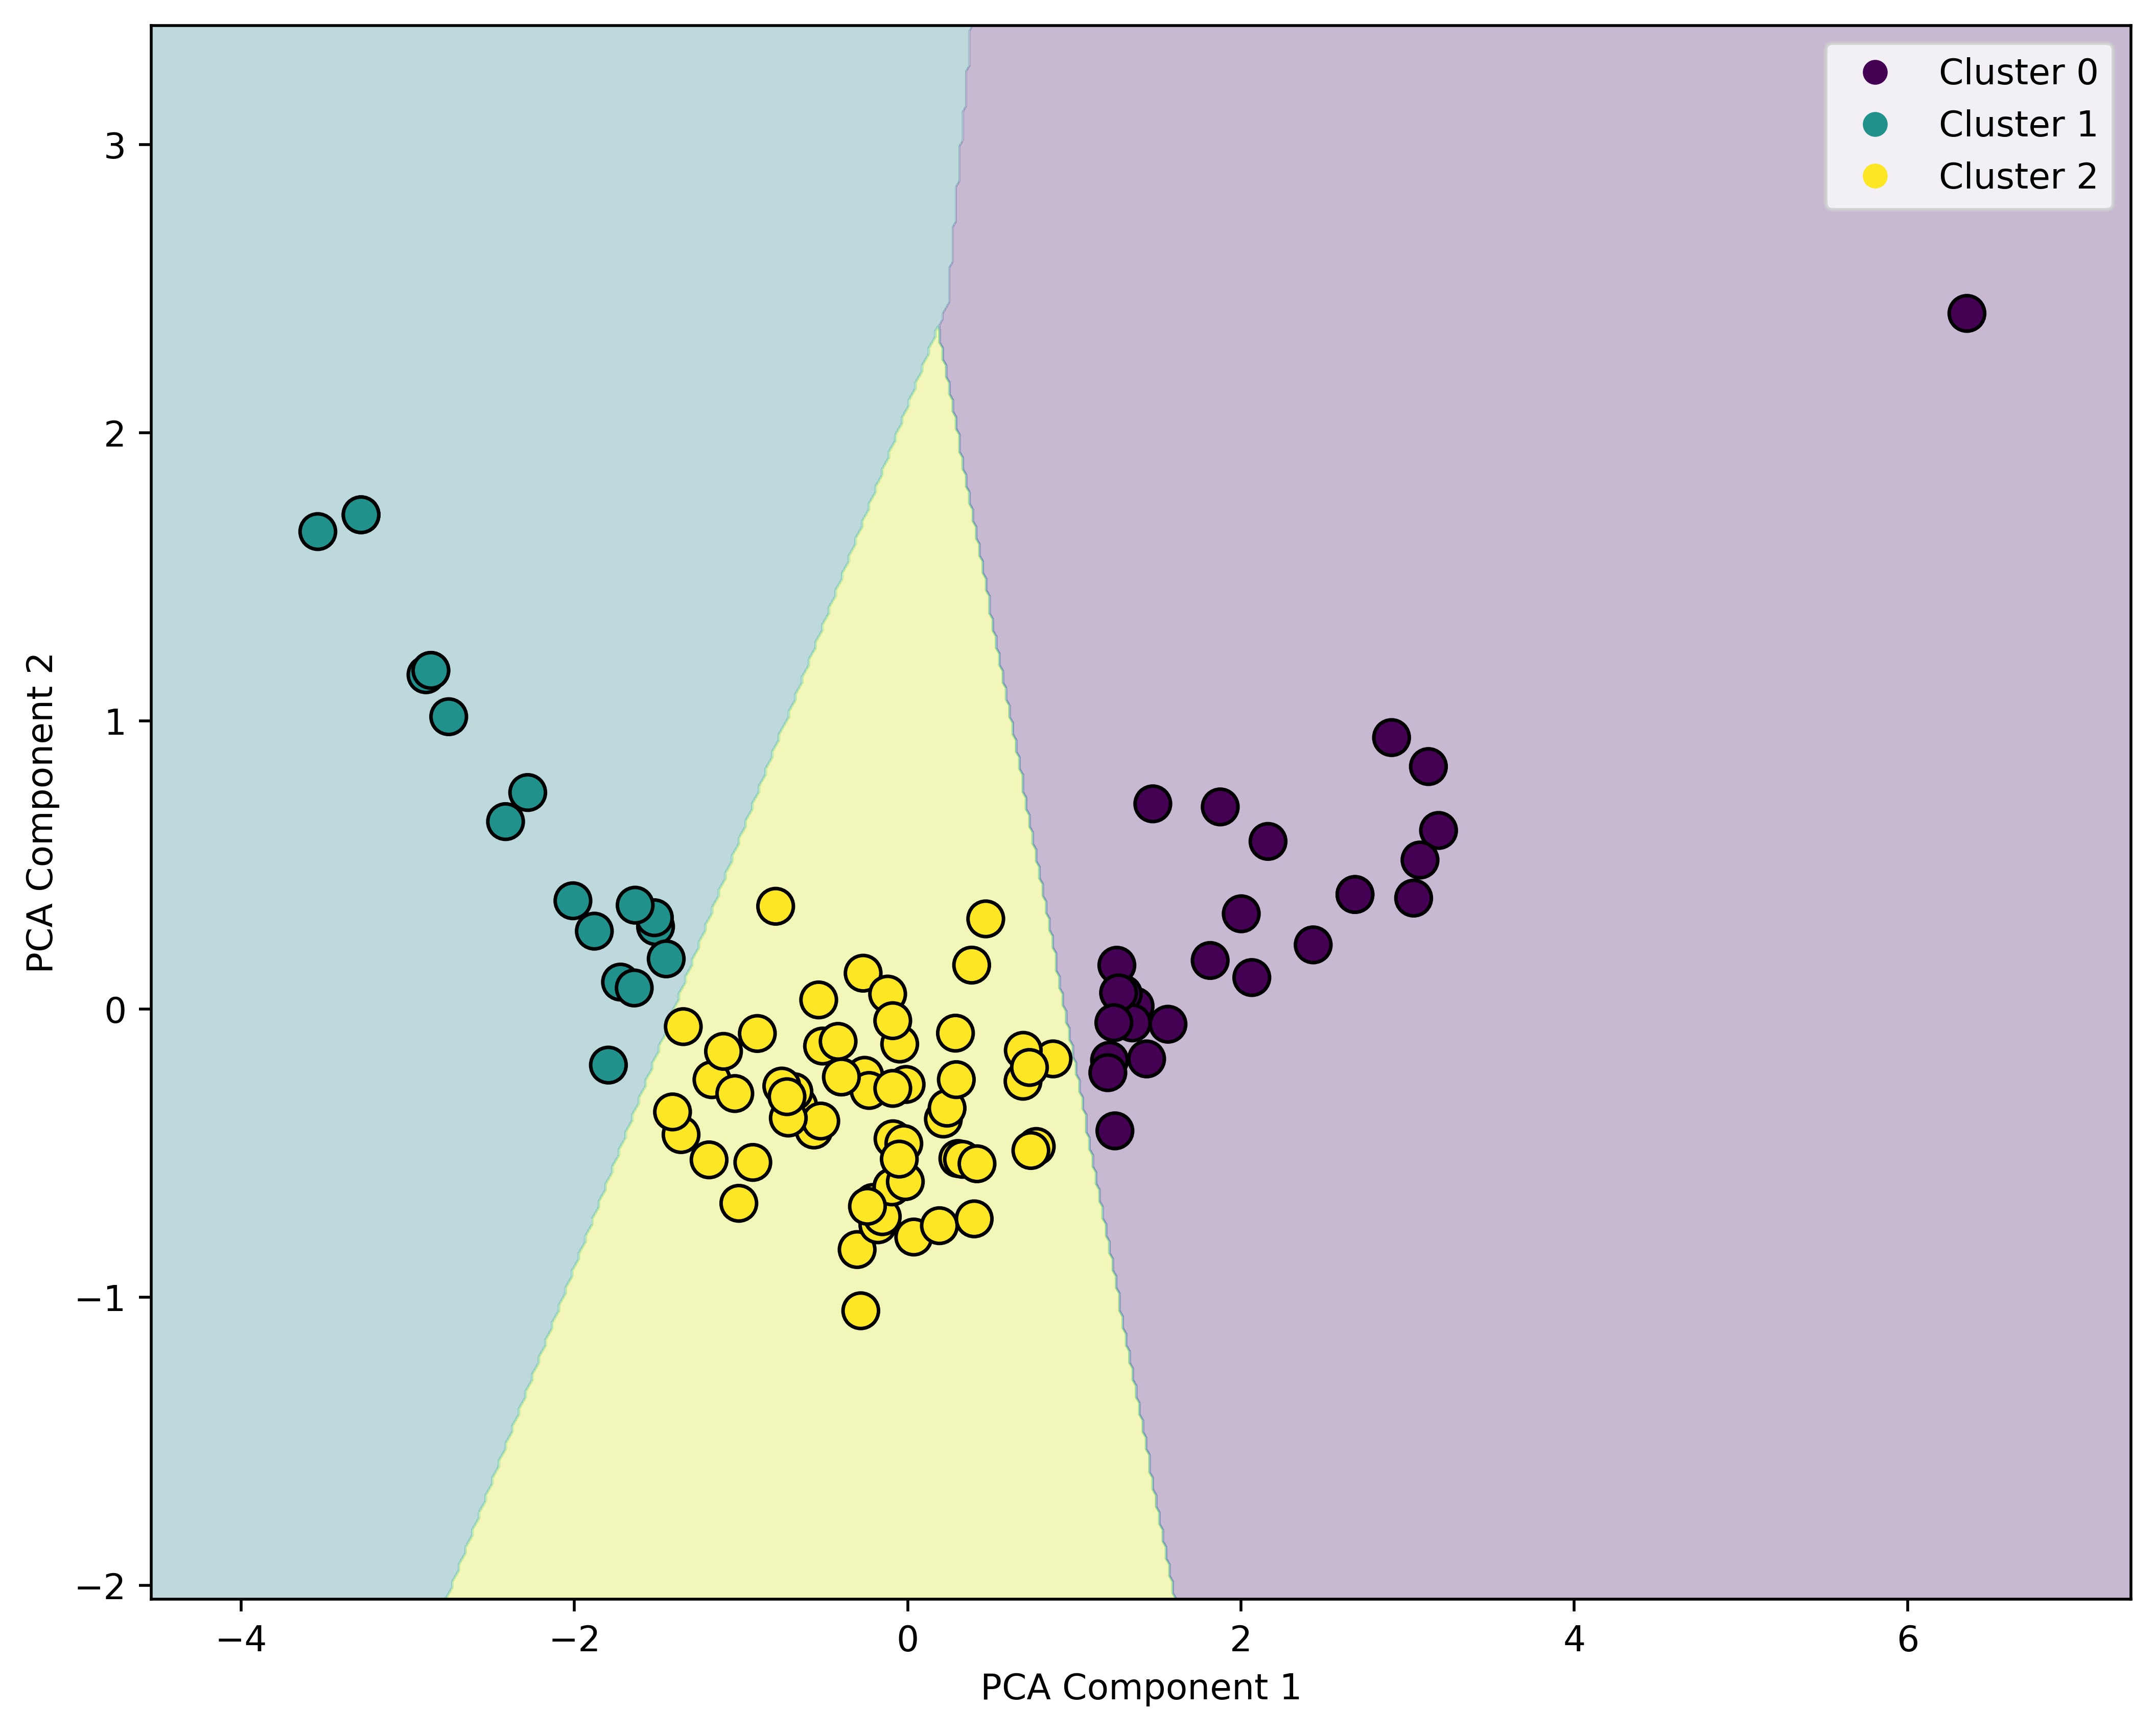

In [ ]:
physical_clusters_list, physical_clustered_topologies_list, physical_silhouette_avg_list = get_score_and_plots(physical_metrics,
                                                                                                               n_clusters=3,
                                                                                                               n_init = 50,
                                                                                                               max_iter = 1500 )

     Diameter (hops)  Average Shortest Path Length (Hops)  \
0                 13                             5.440580   
1                 15                             6.084181   
2                  5                             3.085714   
3                  7                             3.333333   
4                  5                             2.532468   
..               ...                                  ...   
100                6                             2.699346   
101                9                             3.642857   
102                7                             3.000000   
103                6                             2.766082   
104                9                             4.275362   

     Edge Density (Physical Connectivity)  \
0                                0.053140   
1                                0.044633   
2                                0.080952   
3                                0.119048   
4                                0.155844 

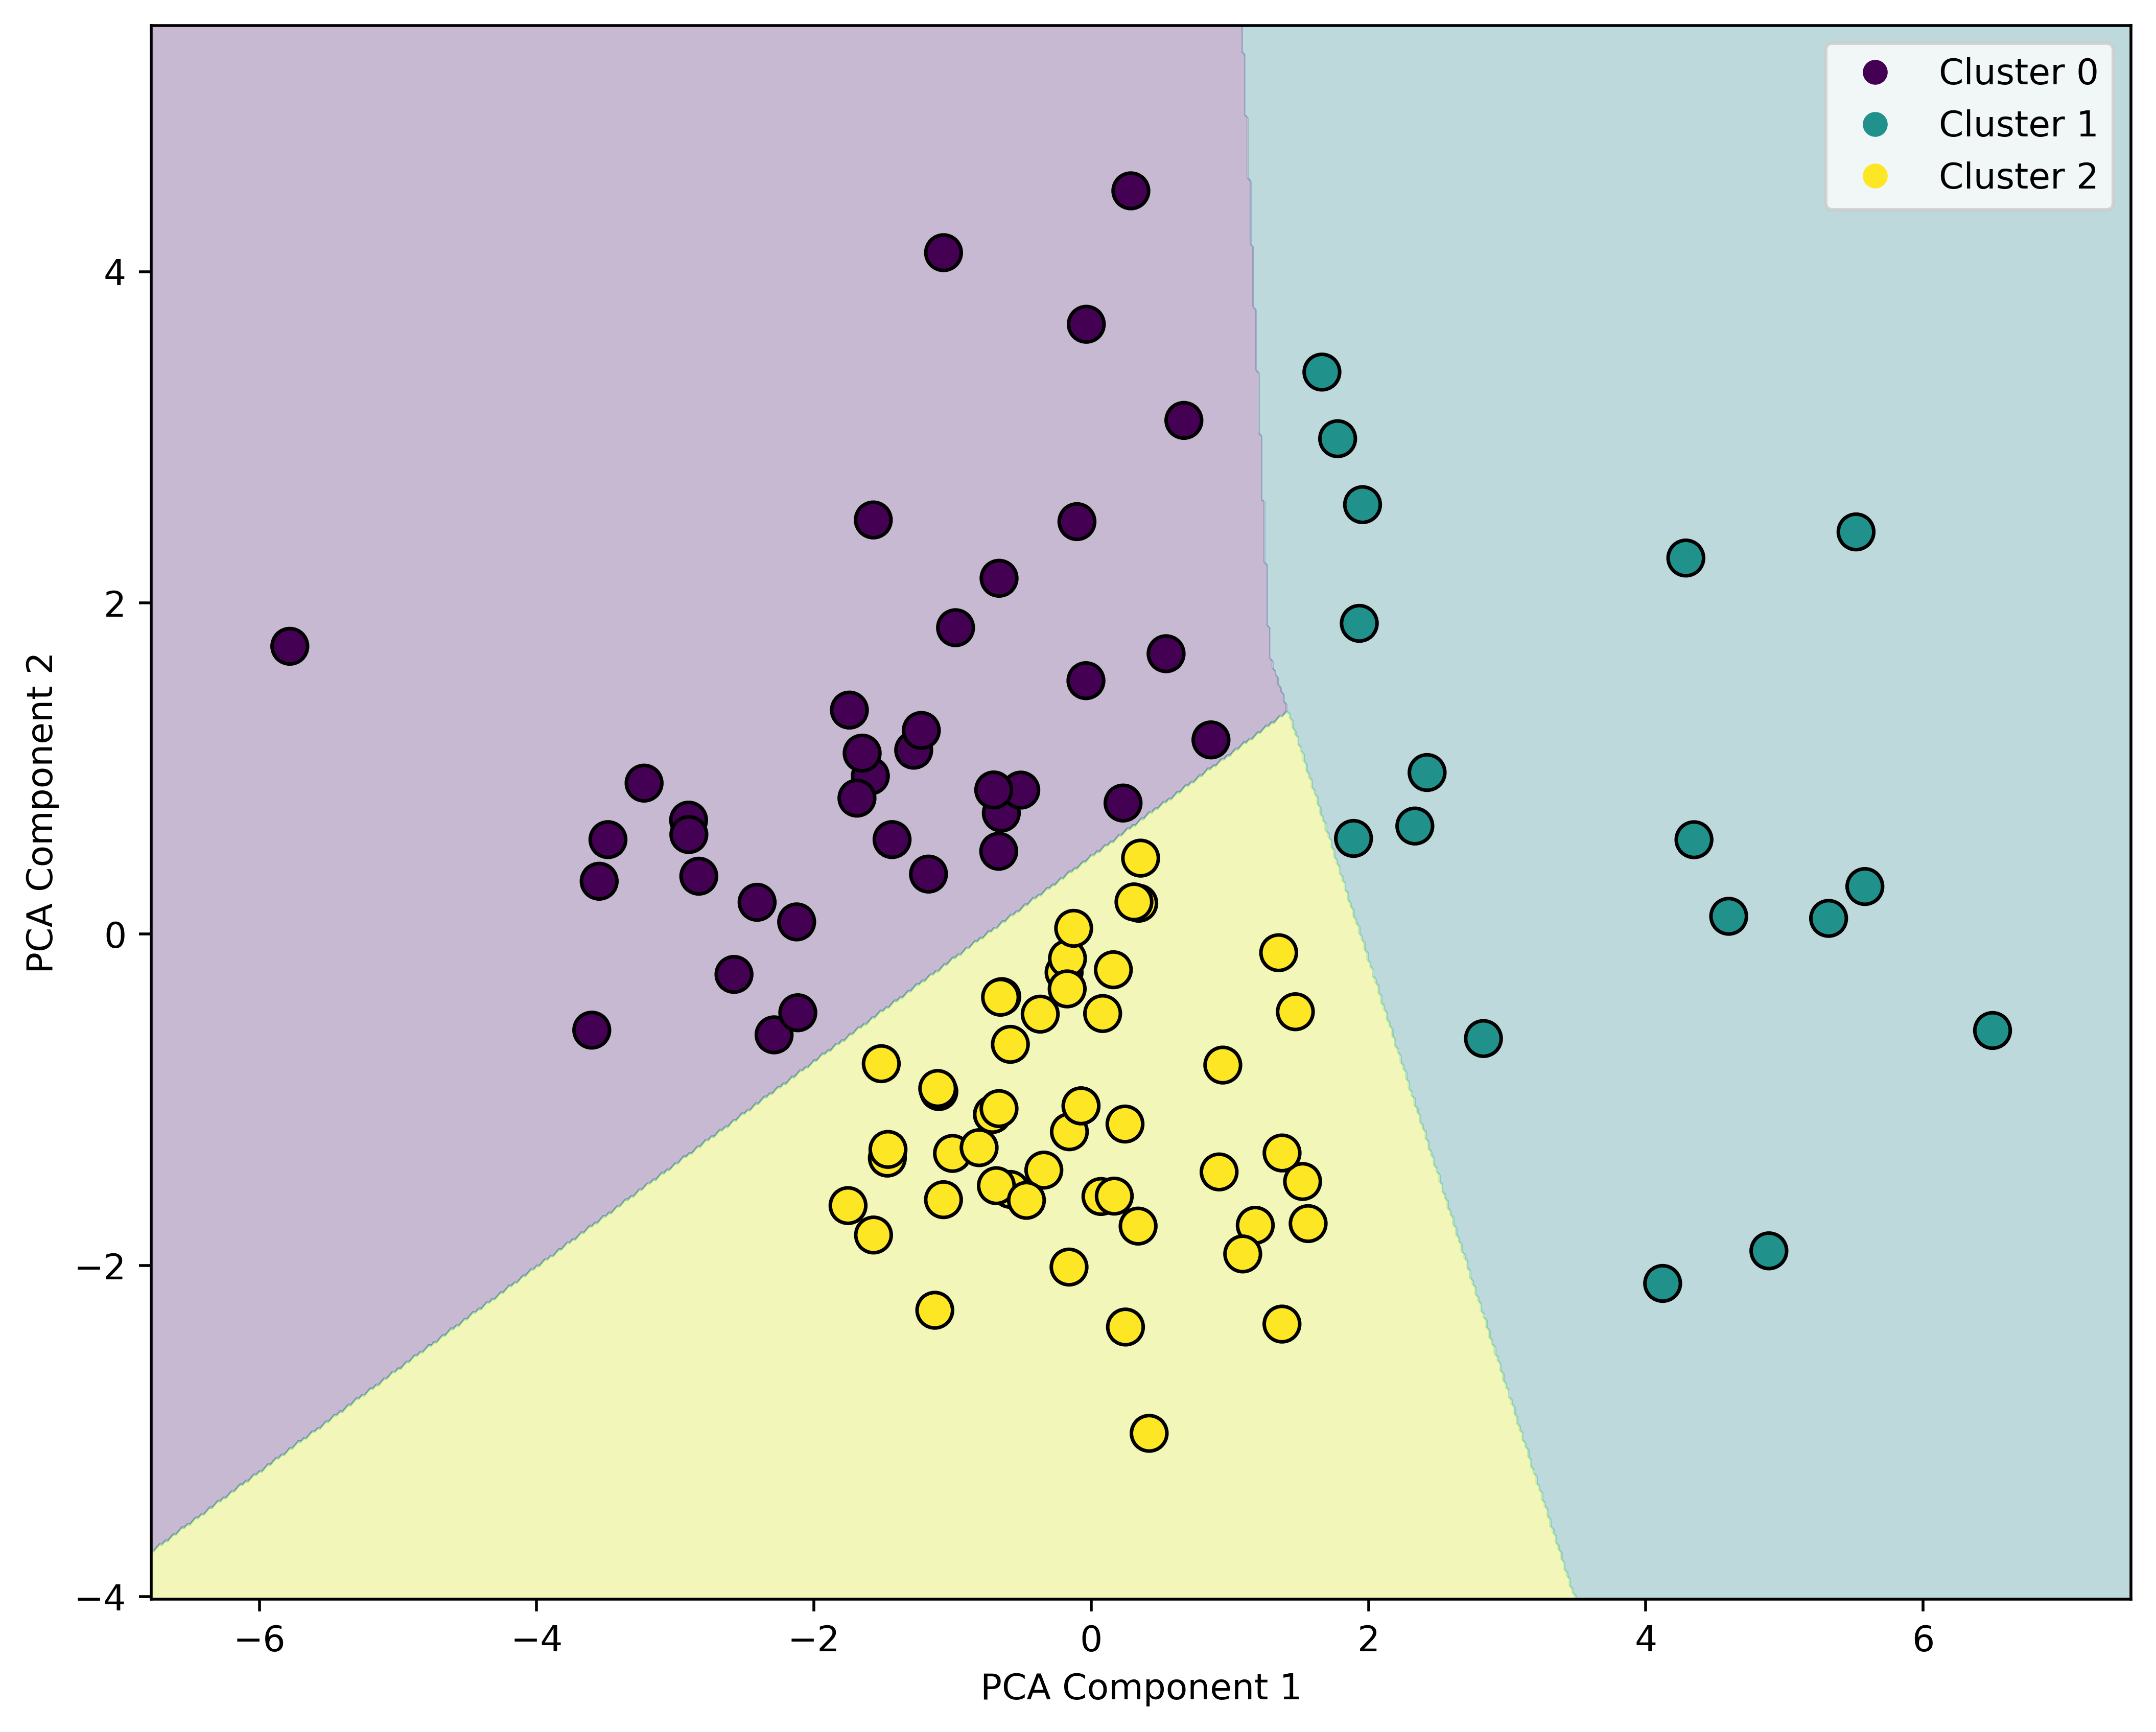

In [ ]:
combined_clusters_list, combined_clustered_topologies_list,  combined_silhouette_avg_list = get_score_and_plots( combined_metrics,
                                                                                                               n_clusters=3,
                                                                                                               n_init = 150,
                                                                                                               max_iter = 1500 )

In [ ]:
spectral_clustered_topologies_list

[  Category Name                                Topologies Assigned
 0       Class 1  [CORONET, DARKSTRAND, SAGO, NEXTGEN, ATMNET, S...
 1       Class 2  [POLSKA, GETNET, GBLNET, CESNET, LAYER42, NETR...
 2       Class 3  [SANET, CERNET, PIONIER, GEANT, ELIBACKBONE, N...,
   Category Name                                Topologies Assigned
 0       Class 1  [CORONET, DARKSTRAND, SAGO, NEXTGEN, ATMNET, S...
 1       Class 2  [POLSKA, GETNET, GBLNET, CESNET, LAYER42, NETR...
 2       Class 3  [SANET, CERNET, PIONIER, GEANT, ELIBACKBONE, N...,
   Category Name                                Topologies Assigned
 0       Class 1  [SANET, CERNET, PIONIER, GEANT, ELIBACKBONE, N...
 1       Class 2  [POLSKA, GETNET, GBLNET, CESNET, LAYER42, NETR...
 2       Class 3  [CORONET, DARKSTRAND, SAGO, NEXTGEN, ATMNET, S...]

In [ ]:
spatial_clustered_topologies_list

[  Category Name                                Topologies Assigned
 0       Class 1  [GETNET, GBLNET, SAGO, NEXTGEN, LAYER42, GTSCZ...
 1       Class 2  [PIONIER, NOEL, DARKSTRAND, POLSKA, ARNES, PIO...
 2       Class 3  [SANET, CORONET, CERNET, GEANT, ELIBACKBONE, N...,
   Category Name                                Topologies Assigned
 0       Class 1  [SANET, CORONET, CERNET, GEANT, ELIBACKBONE, N...
 1       Class 2  [GETNET, GBLNET, SAGO, NEXTGEN, LAYER42, GTSCZ...
 2       Class 3  [PIONIER, NOEL, DARKSTRAND, POLSKA, ARNES, PIO...,
   Category Name                                Topologies Assigned
 0       Class 1  [SANET, CORONET, CERNET, GEANT, ELIBACKBONE, N...
 1       Class 2  [GETNET, GBLNET, SAGO, NEXTGEN, LAYER42, GTSCZ...
 2       Class 3  [PIONIER, NOEL, DARKSTRAND, POLSKA, ARNES, PIO...]

In [ ]:
physical_clustered_topologies_list

[  Category Name                                Topologies Assigned
 0       Class 1  [SANET, CORONET, DARKSTRAND, TATANID, SAGO, NE...
 1       Class 2  [POLSKA, GETNET, GBLNET, CESNET, LAYER42, NETR...
 2       Class 3  [CERNET, PIONIER, GEANT, ELIBACKBONE, NOEL, NO...,
   Category Name                                Topologies Assigned
 0       Class 1  [CERNET, PIONIER, GEANT, ELIBACKBONE, NOEL, NO...
 1       Class 2  [SANET, CORONET, DARKSTRAND, TATANID, SAGO, NE...
 2       Class 3  [POLSKA, GETNET, GBLNET, CESNET, LAYER42, NETR...,
   Category Name                                Topologies Assigned
 0       Class 1  [CERNET, PIONIER, GEANT, ELIBACKBONE, NOEL, NO...
 1       Class 2  [SANET, CORONET, DARKSTRAND, TATANID, SAGO, NE...
 2       Class 3  [POLSKA, GETNET, GBLNET, CESNET, LAYER42, NETR...]

In [ ]:
combined_clustered_topologies_list

[  Category Name                                Topologies Assigned
 0       Class 1  [SANET, CORONET, DARKSTRAND, PIONIERL3, TATANI...
 1       Class 2  [GETNET, GBLNET, LAYER42, NETRAIL, SANREN, EPO...
 2       Class 3  [CERNET, PIONIER, GEANT, ELIBACKBONE, NOEL, PO...,
   Category Name                                Topologies Assigned
 0       Class 1  [SANET, CORONET, DARKSTRAND, PIONIERL3, TATANI...
 1       Class 2  [GETNET, GBLNET, LAYER42, NETRAIL, SANREN, EPO...
 2       Class 3  [CERNET, PIONIER, GEANT, ELIBACKBONE, NOEL, PO...,
   Category Name                                Topologies Assigned
 0       Class 1  [CERNET, PIONIER, GEANT, ELIBACKBONE, NOEL, PO...
 1       Class 2  [GETNET, GBLNET, LAYER42, NETRAIL, SANREN, EPO...
 2       Class 3  [SANET, CORONET, DARKSTRAND, PIONIERL3, TATANI...]

In [ ]:
spectral_clustered_topologies_list[0].to_csv('spectral_clustered_topologies_random_seed_42.csv', index=False)
spectral_clustered_topologies_list[1].to_csv('spectral_clustered_topologies_random_seed_7.csv', index=False)
spectral_clustered_topologies_list[2].to_csv('spectral_clustered_topologies_random_seed_108.csv', index=False)

In [ ]:
spatial_clustered_topologies_list[0].to_csv('spatial_clustered_topologies_random_seed_42.csv', index=False)
spatial_clustered_topologies_list[1].to_csv('spatial_clustered_topologies_random_seed_7.csv', index=False)
spatial_clustered_topologies_list[2].to_csv('spatial_clustered_topologies_random_seed_108.csv', index=False)

In [ ]:
physical_clustered_topologies_list[0].to_csv('physical_clustered_topologies_random_seed_42.csv', index=False)
physical_clustered_topologies_list[1].to_csv('physical_clustered_topologies_random_seed_7.csv', index=False)
physical_clustered_topologies_list[2].to_csv('physical_clustered_topologies_random_seed_108.csv', index=False)

In [ ]:
combined_clustered_topologies_list[0].to_csv('combined_clustered_topologies_random_seed_42.csv', index=False)
combined_clustered_topologies_list[1].to_csv('combined_clustered_topologies_random_seed_7.csv', index=False)
combined_clustered_topologies_list[2].to_csv('combined_clustered_topologies_random_seed_108.csv', index=False)

In [ ]:
# Create a dictionary for each set of metrics
metrics = {
    'Metrics': ['Spectral', 'Spatial', 'Physical', 'Combined'],
    'Variance PC1': [0.47, 0.83, 0.87, 0.49],
    'Variance PC2': [0.36, 0.15, 0.12, 0.26],
    'Total Variance': [0.83, 0.98, 0.99, 0.76],
    'Accuracy': [0.9809523809523809, 1.0, 1.0, 1.0],
    'F1 Score': [0.9809567528237605, 1.0, 1.0, 1.0],
    'Precision': [0.9817006802721088, 1.0, 1.0, 1.0],
    'Recall': [0.9809523809523809, 1.0, 1.0, 1.0],
    'AUC-ROC': [1.0, 1.0, 1.0, 1.0],
    'Margin': [0.22107128158757422, 0.23189128709663, 0.23769533691391528, 0.2765939198212106]
}

# Create the DataFrame
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('clustering_results.csv', index=False)